# ML Assignment 2 — Diabetes Classification (Local Training)

This notebook trains **6 classification models** on the provided dataset and saves the trained models to disk.

**Models required (per assignment):** Logistic Regression, Decision Tree, kNN, Naive Bayes, Random Forest, XGBoost. citeturn28search2

**Metrics required:** Accuracy, AUC, Precision, Recall, F1, MCC. citeturn28search2

> Place `diabetes_data_upload.csv` in the same folder as this notebook before running.


In [25]:
# If running in a fresh environment, install dependencies (uncomment if needed)
# !pip install -U pandas numpy scikit-learn xgboost joblib matplotlib seaborn


In [26]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception as e:
    XGBOOST_AVAILABLE = False
    print('XGBoost not available. Install with: pip install xgboost')

RANDOM_STATE = 42
DATA_PATH = Path('diabetes_data_upload.csv')
MODEL_DIR = Path('model')
RESULTS_DIR = Path('results')
MODEL_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)


XGBoost not available. Install with: pip install xgboost


In [27]:
# 1) Load dataset
assert DATA_PATH.exists(), f"CSV not found at {DATA_PATH.resolve()}"
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (520, 17)


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [28]:
# 2) Clean column names (spaces -> underscores) for convenience

def clean_columns(cols):
    out = []
    for c in cols:
        c2 = c.strip().replace(' ', '_')
        c2 = c2.replace('-', '_')
        out.append(c2)
    return out

df.columns = clean_columns(df.columns)
print(df.columns.tolist())


['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden_weight_loss', 'weakness', 'Polyphagia', 'Genital_thrush', 'visual_blurring', 'Itching', 'Irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'Alopecia', 'Obesity', 'class']


In [29]:
# 3) Preprocess: map categorical Yes/No -> 1/0, Gender -> 1/0, target class -> 1/0

TARGET_COL = 'class'

# Identify binary Yes/No columns (everything except Age, Gender, class)
feature_cols = [c for c in df.columns if c != TARGET_COL]

# Robust mapping for Yes/No
yn_map = {'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, True: 1, False: 0}

def preprocess_dataframe(df_in: pd.DataFrame) -> pd.DataFrame:
    dfp = df_in.copy()
    # Ensure expected columns exist
    if 'Gender' not in dfp.columns and 'Gender' in [c.replace('_',' ') for c in dfp.columns]:
        pass
    # Map Gender
    if 'Gender' in dfp.columns:
        dfp['Gender'] = dfp['Gender'].map({'Male': 1, 'Female': 0, 'male': 1, 'female': 0})
    # Map Yes/No for object columns other than target
    for c in dfp.columns:
        if c == TARGET_COL:
            continue
        if dfp[c].dtype == 'object':
            # If looks like Yes/No, map
            uniq = set(dfp[c].dropna().unique().tolist())
            if uniq.issubset(set(['Yes','No','yes','no'])):
                dfp[c] = dfp[c].map(yn_map)
    # Convert Age to numeric if needed
    if 'Age' in dfp.columns:
        dfp['Age'] = pd.to_numeric(dfp['Age'], errors='coerce')
    return dfp

# Apply preprocessing
pdf = preprocess_dataframe(df)

# Map target
pdf[TARGET_COL] = pdf[TARGET_COL].map({'Positive': 1, 'Negative': 0, 'positive': 1, 'negative': 0})

# Drop rows with missing after mapping
before = len(pdf)
pdf = pdf.dropna()
after = len(pdf)
print(f"Dropped {before-after} rows due to NA after preprocessing")

X = pdf.drop(columns=[TARGET_COL])
y = pdf[TARGET_COL].astype(int)

FEATURE_ORDER = X.columns.tolist()
print('Feature count:', len(FEATURE_ORDER))
print('Class balance:', y.value_counts().to_dict())
X.head()

Dropped 0 rows due to NA after preprocessing
Feature count: 16
Class balance: {1: 320, 0: 200}


,Age,Gender,Polyuria,Polydipsia,sudden_weight_loss,weakness,Polyphagia,Genital_thrush,visual_blurring,Itching,Irritability,delayed_healing,partial_paresis,muscle_stiffness,Alopecia,Obesity
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1


In [30]:
# 4) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (416, 16) Test: (104, 16)


In [31]:
# 5) Define models (6 required)

models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ]),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'kNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=7))
    ]),
    'Naive Bayes (Gaussian)': GaussianNB(),
    'Random Forest': RandomForestClassifier(
        n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1
    )
}

if XGBOOST_AVAILABLE:
    models['XGBoost'] = XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        eval_metric='logloss'
    )
else:
    print('Skipping XGBoost training because xgboost is not installed.')

list(models.keys())

Skipping XGBoost training because xgboost is not installed.


['Logistic Regression',
 'Decision Tree',
 'kNN',
 'Naive Bayes (Gaussian)',
 'Random Forest']

In [32]:
# 6) Train and evaluate

def compute_metrics(y_true, y_pred, y_prob=None):
    out = {}
    out['accuracy'] = accuracy_score(y_true, y_pred)
    # AUC needs probability scores
    if y_prob is not None:
        out['auc'] = roc_auc_score(y_true, y_prob)
    else:
        out['auc'] = np.nan
    out['precision'] = precision_score(y_true, y_pred, zero_division=0)
    out['recall'] = recall_score(y_true, y_pred, zero_division=0)
    out['f1'] = f1_score(y_true, y_pred, zero_division=0)
    out['mcc'] = matthews_corrcoef(y_true, y_pred)
    return out

results = []
conf_mats = {}
reports = {}

for name, model in models.items():
    print('' + '='*70)
    print('Training:', name)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = None
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        scores = model.decision_function(X_test)
        # scale scores to 0-1 for AUC compatibility if needed
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)

    met = compute_metrics(y_test, y_pred, y_prob)
    met['model'] = name
    results.append(met)

    cm = confusion_matrix(y_test, y_pred)
    conf_mats[name] = cm
    reports[name] = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

# Summary table
results_df = pd.DataFrame(results).set_index('model').sort_values('auc', ascending=False)
results_df

Training: Logistic Regression
Training: Decision Tree
Training: kNN
Training: Naive Bayes (Gaussian)
Training: Random Forest


,accuracy,auc,precision,recall,f1,mcc
model,,,,,,
Random Forest,0.990385,1.000000,1.000000,0.984375,0.992126,0.979983
Decision Tree,0.990385,0.992188,1.000000,0.984375,0.992126,0.979983
Logistic Regression,0.942308,0.990234,0.983333,0.921875,0.951613,0.883181
Naive Bayes (Gaussian),0.942308,0.986328,0.967742,0.937500,0.952381,0.879970
kNN,0.932692,0.979883,0.983051,0.906250,0.943089,0.865340


In [33]:
# 7) Save metrics + confusion matrices
results_path = RESULTS_DIR / 'metrics.csv'
results_df.to_csv(results_path)
print('Saved:', results_path.resolve())

# Save classification reports
with open(RESULTS_DIR / 'classification_reports.json', 'w', encoding='utf-8') as f:
    json.dump(reports, f, indent=2)
print('Saved reports JSON')

# Save confusion matrices
np.savez(RESULTS_DIR / 'confusion_matrices.npz', **{k: v for k,v in conf_mats.items()})
print('Saved confusion matrices')


Saved: C:\D-Drive\D\Personal\MTech\Sem1\Assignments\ML_2\results\metrics.csv
Saved reports JSON
Saved confusion matrices


Best model (by AUC): Random Forest


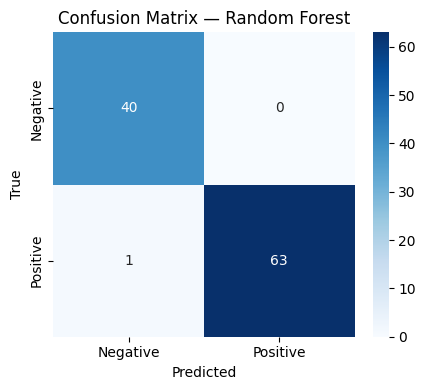

In [34]:
# 8) Visualize confusion matrix for best model
best_model_name = results_df.index[0]
print('Best model (by AUC):', best_model_name)
cm = conf_mats[best_model_name]
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title(f'Confusion Matrix — {best_model_name}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()


In [35]:
# 9) Save trained models + metadata

# Persist each model
for name, model in models.items():
    fname = name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
    fpath = MODEL_DIR / f'{fname}.joblib'
    joblib.dump(model, fpath)
    print('Saved model:', fpath)

metadata = {
   # 'created_at': datetime.now().isoformat(),
    'feature_order': FEATURE_ORDER,
    'target_col': TARGET_COL,
    'target_mapping': {'Positive': 1, 'Negative': 0},
    'gender_mapping': {'Male': 1, 'Female': 0},
    'yes_no_mapping': {'Yes': 1, 'No': 0},
    'notes': 'Preprocessing: spaces->underscores; Gender and Yes/No mapped to 0/1; drop NA rows.'
}
with open(MODEL_DIR / 'metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2)
print('Saved metadata:', (MODEL_DIR / 'metadata.json').resolve())


Saved model: model\logistic_regression.joblib
Saved model: model\decision_tree.joblib
Saved model: model\knn.joblib
Saved model: model\naive_bayes_gaussian.joblib
Saved model: model\random_forest.joblib
Saved metadata: C:\D-Drive\D\Personal\MTech\Sem1\Assignments\ML_2\model\metadata.json


## Next
- Run `streamlit run app.py` to use the saved models in a UI.
- The Streamlit app expects the `model/` and `results/` folders created by this notebook.
